<a href="https://colab.research.google.com/github/Klop4ikk/3int/blob/main/%D0%98%D0%BD%D1%82%D0%B5%D0%BD%D1%81%D0%B8%D0%B23_%D0%A4%D0%BB%D0%B5%D0%B9%D1%88%D0%B3%D0%B0%D1%83%D1%8D%D1%80.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Анализ и загрузка данных

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import requests
from io import BytesIO
import statsmodels
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

%matplotlib inline

In [2]:
url = "https://github.com/samoletpanfilov/reinforcement_task/raw/refs/heads/master/data/train.xlsx"  # Ссылка должна содержать raw
response = requests.get(url)
df_ts = pd.read_excel(BytesIO(response.content), engine='openpyxl')
df_ts.head(15)

,dt,Цена на арматуру
0,2015-01-05,32900
1,2015-01-12,32500
2,2015-01-19,32000
3,2015-01-26,30700
4,2015-02-02,30300
5,2015-02-09,30300
6,2015-02-16,30100
7,2015-02-23,29400
8,2015-03-02,29200
9,2015-03-09,29000


In [3]:
df_ts.describe()

,dt,Цена на арматуру
count,400,400.000000
mean,2018-11-01 12:00:00,39229.475000
min,2015-01-05 00:00:00,21000.000000
25%,2016-12-03 06:00:00,31075.000000
50%,2018-11-01 12:00:00,35450.000000
75%,2020-09-29 18:00:00,42000.000000
max,2022-08-29 00:00:00,79000.000000
std,NaN,13407.979668


In [4]:
df_ts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 2 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   dt                400 non-null    datetime64[ns]
 1   Цена на арматуру  400 non-null    int64         
dtypes: datetime64[ns](1), int64(1)
memory usage: 6.4 KB


In [5]:
df_ts.shape

(400, 2)

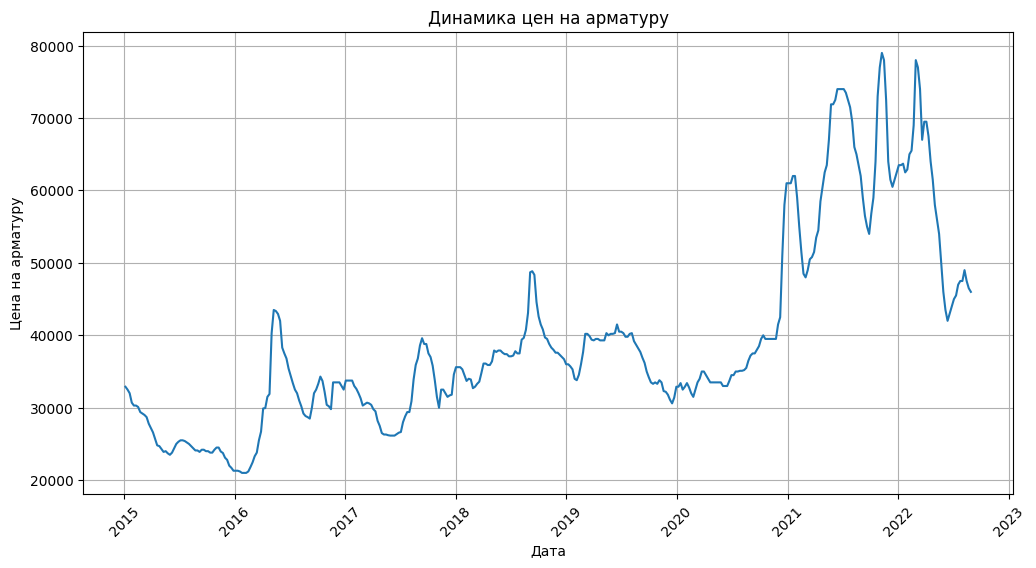

In [6]:
# Строим график
plt.figure(figsize=(12, 6))
plt.plot(df_ts["dt"], df_ts["Цена на арматуру"], marker='', linestyle='-')

# Настроим оси и заголовок
plt.xlabel("Дата")
plt.ylabel("Цена на арматуру")
plt.title("Динамика цен на арматуру")
plt.grid(True)

# Улучшим читаемость меток дат
plt.xticks(rotation=45)

# Показываем график
plt.show()

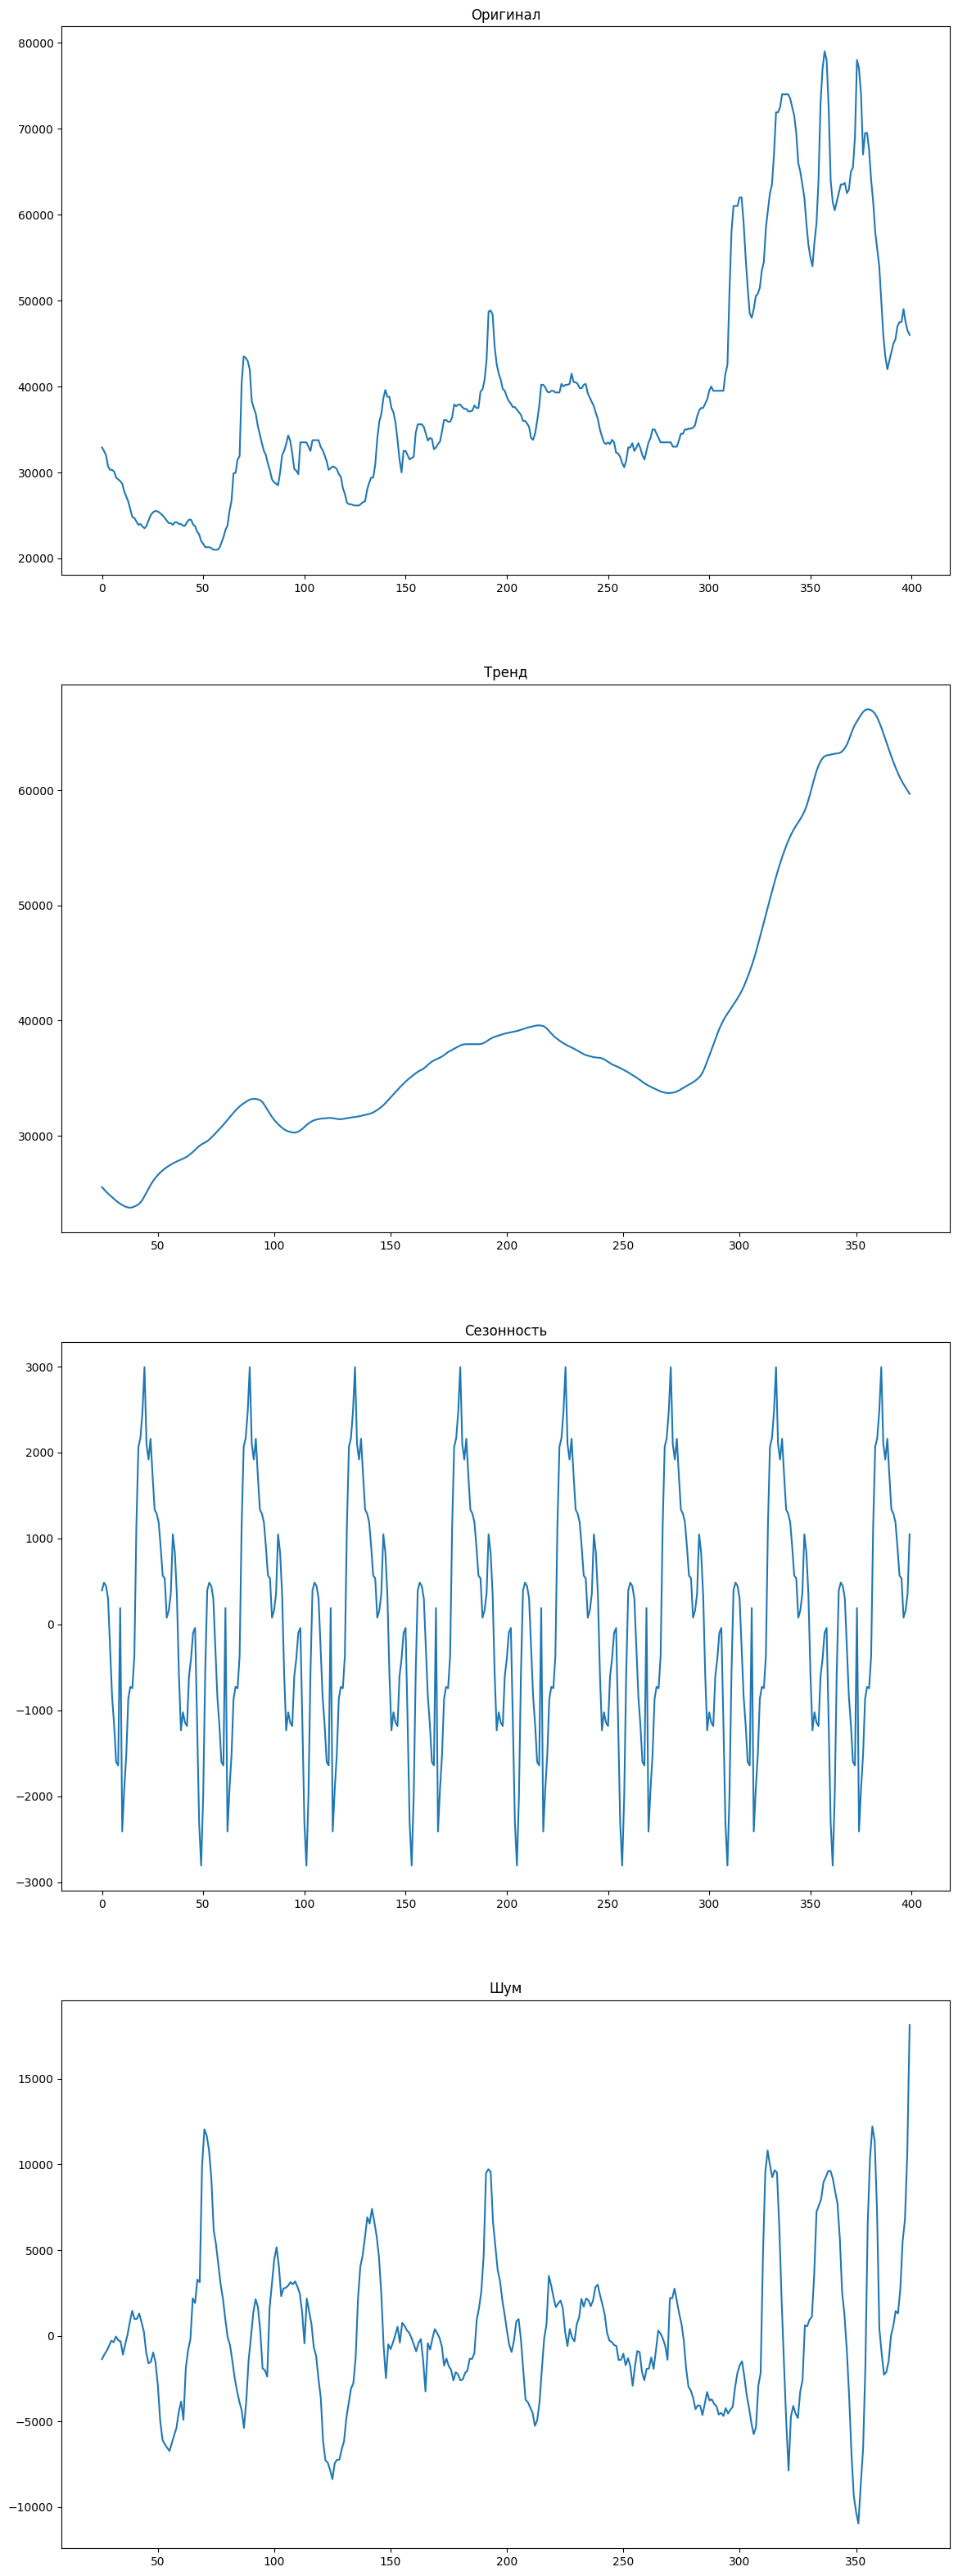

In [7]:
# Разложим ряд на компоненты и проверим ответы на вопросы

fig, ax = plt.subplots(nrows=4, ncols=1, figsize=(14, 40))
decompose = seasonal_decompose(df_ts['Цена на арматуру'],period = 52)

ax[0].set_title('Оригинал')
ax[1].set_title('Тренд')
ax[2].set_title('Сезонность')
ax[3].set_title('Шум')

decompose.observed.plot(ax=ax[0])
decompose.trend.plot(ax=ax[1])
decompose.seasonal.plot(ax=ax[2])
decompose.resid.plot(ax=ax[3]);

In [8]:
# Получил 'сырые' значения автокорреляций
acf(df_ts["Цена на арматуру"] ,nlags = 100, fft = False)

array([1.        , 0.99138242, 0.97367714, 0.95122039, 0.92740427,
       0.90357365, 0.88126621, 0.8606089 , 0.84235253, 0.82671727,
       0.81349611, 0.8020525 , 0.7925797 , 0.78508849, 0.78019657,
       0.77692922, 0.77376814, 0.76901294, 0.76227632, 0.75319077,
       0.74261145, 0.7309889 , 0.71862345, 0.7046383 , 0.68939965,
       0.67325908, 0.65612584, 0.63820561, 0.62109396, 0.60459259,
       0.58872289, 0.57435372, 0.56120831, 0.54900152, 0.5377084 ,
       0.5271632 , 0.51674918, 0.5068141 , 0.49691253, 0.48636205,
       0.47460061, 0.4600824 , 0.44257206, 0.42285538, 0.40223733,
       0.38033844, 0.35769402, 0.33517203, 0.31316745, 0.29306128,
       0.27522925, 0.2595102 , 0.24447201, 0.23086215, 0.21896621,
       0.20859445, 0.1993889 , 0.19088593, 0.18300826, 0.1757314 ,
       0.16880023, 0.16166525, 0.15350675, 0.14370082, 0.13267574,
       0.12198755, 0.11231837, 0.10288107, 0.0929827 , 0.08286002,
       0.07336018, 0.06476539, 0.05709237, 0.05068118, 0.04473

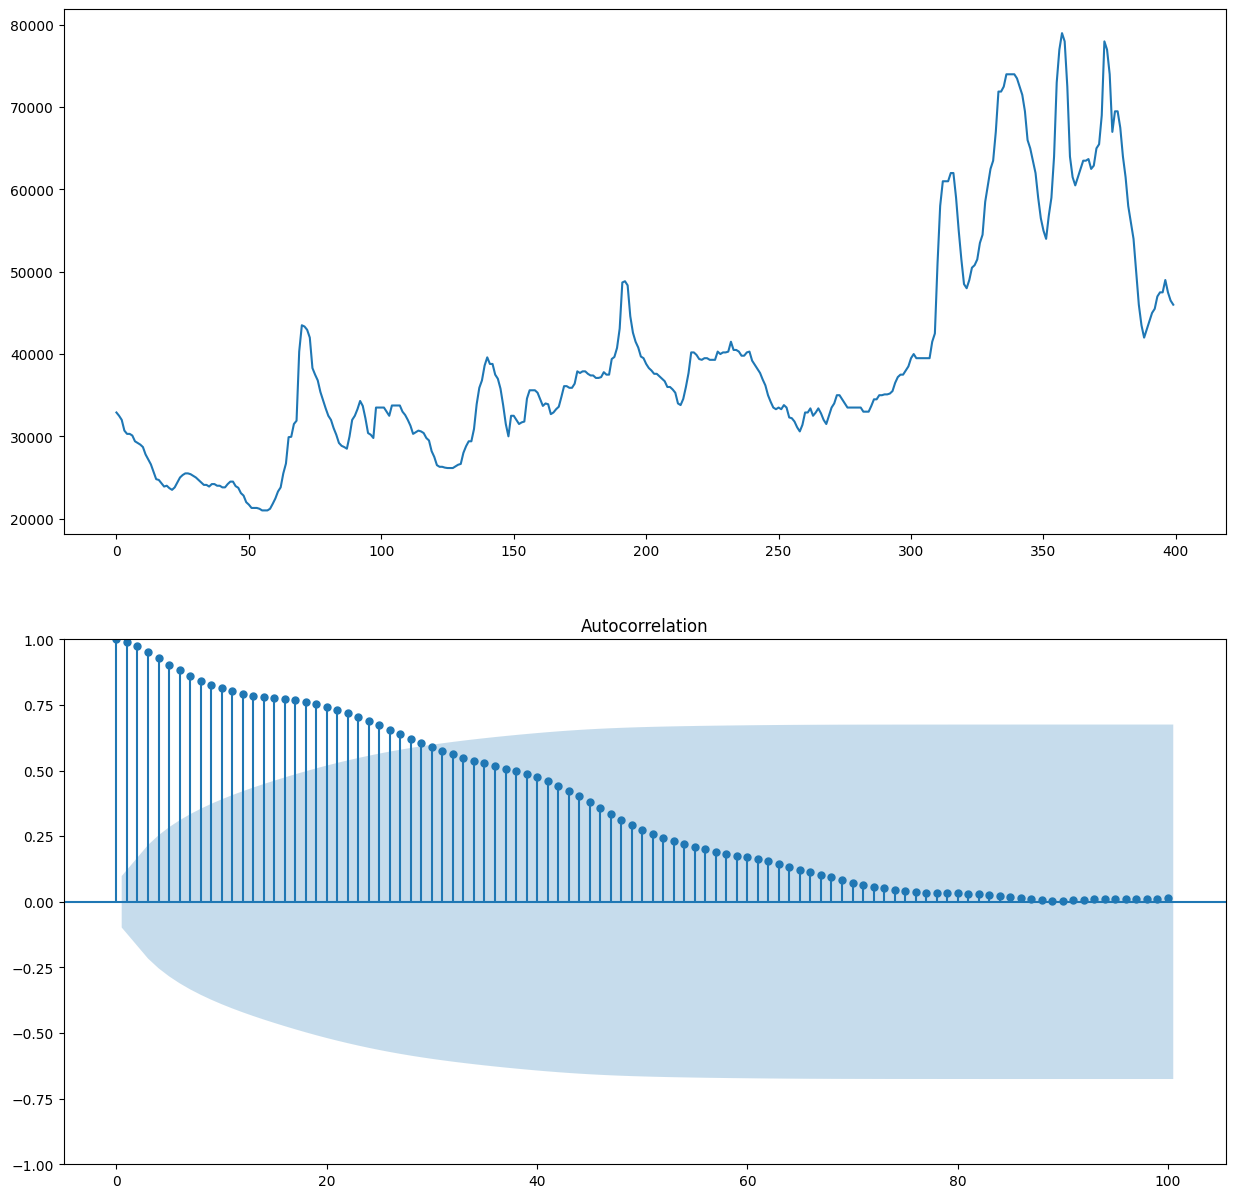

In [9]:
# Визуализация автокорреляции

fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))
df_ts['Цена на арматуру'].plot(ax=ax[0])
plot_acf(df_ts['Цена на арматуру'], lags=100, ax=ax[1]);

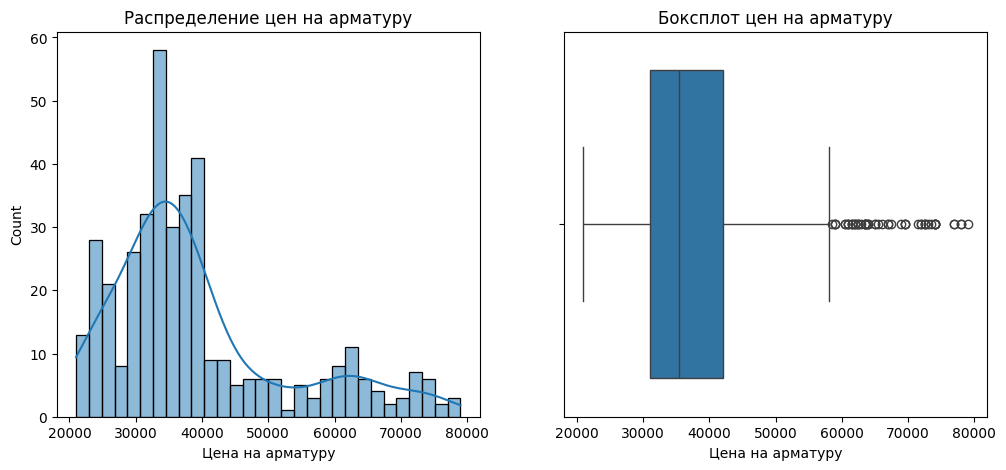

In [10]:
plt.figure(figsize=(12, 5))

# Гистограмма
plt.subplot(1, 2, 1)
sns.histplot(df_ts["Цена на арматуру"], bins=30, kde=True)
plt.title("Распределение цен на арматуру")

# Боксплот
plt.subplot(1, 2, 2)
sns.boxplot(x=df_ts["Цена на арматуру"])
plt.title("Боксплот цен на арматуру")

plt.show()

In [11]:
result = adfuller(df_ts["Цена на арматуру"])
print("ADF Statistic:", result[0])
print("p-value:", result[1])

if result[1] < 0.05:
    print("Ряд стационарен (отвергаем H0)")
else:
    print("Ряд нестационарен (не отвергаем H0)")

ADF Statistic: -1.9258699893713456
p-value: 0.31999061025699155
Ряд нестационарен (не отвергаем H0)


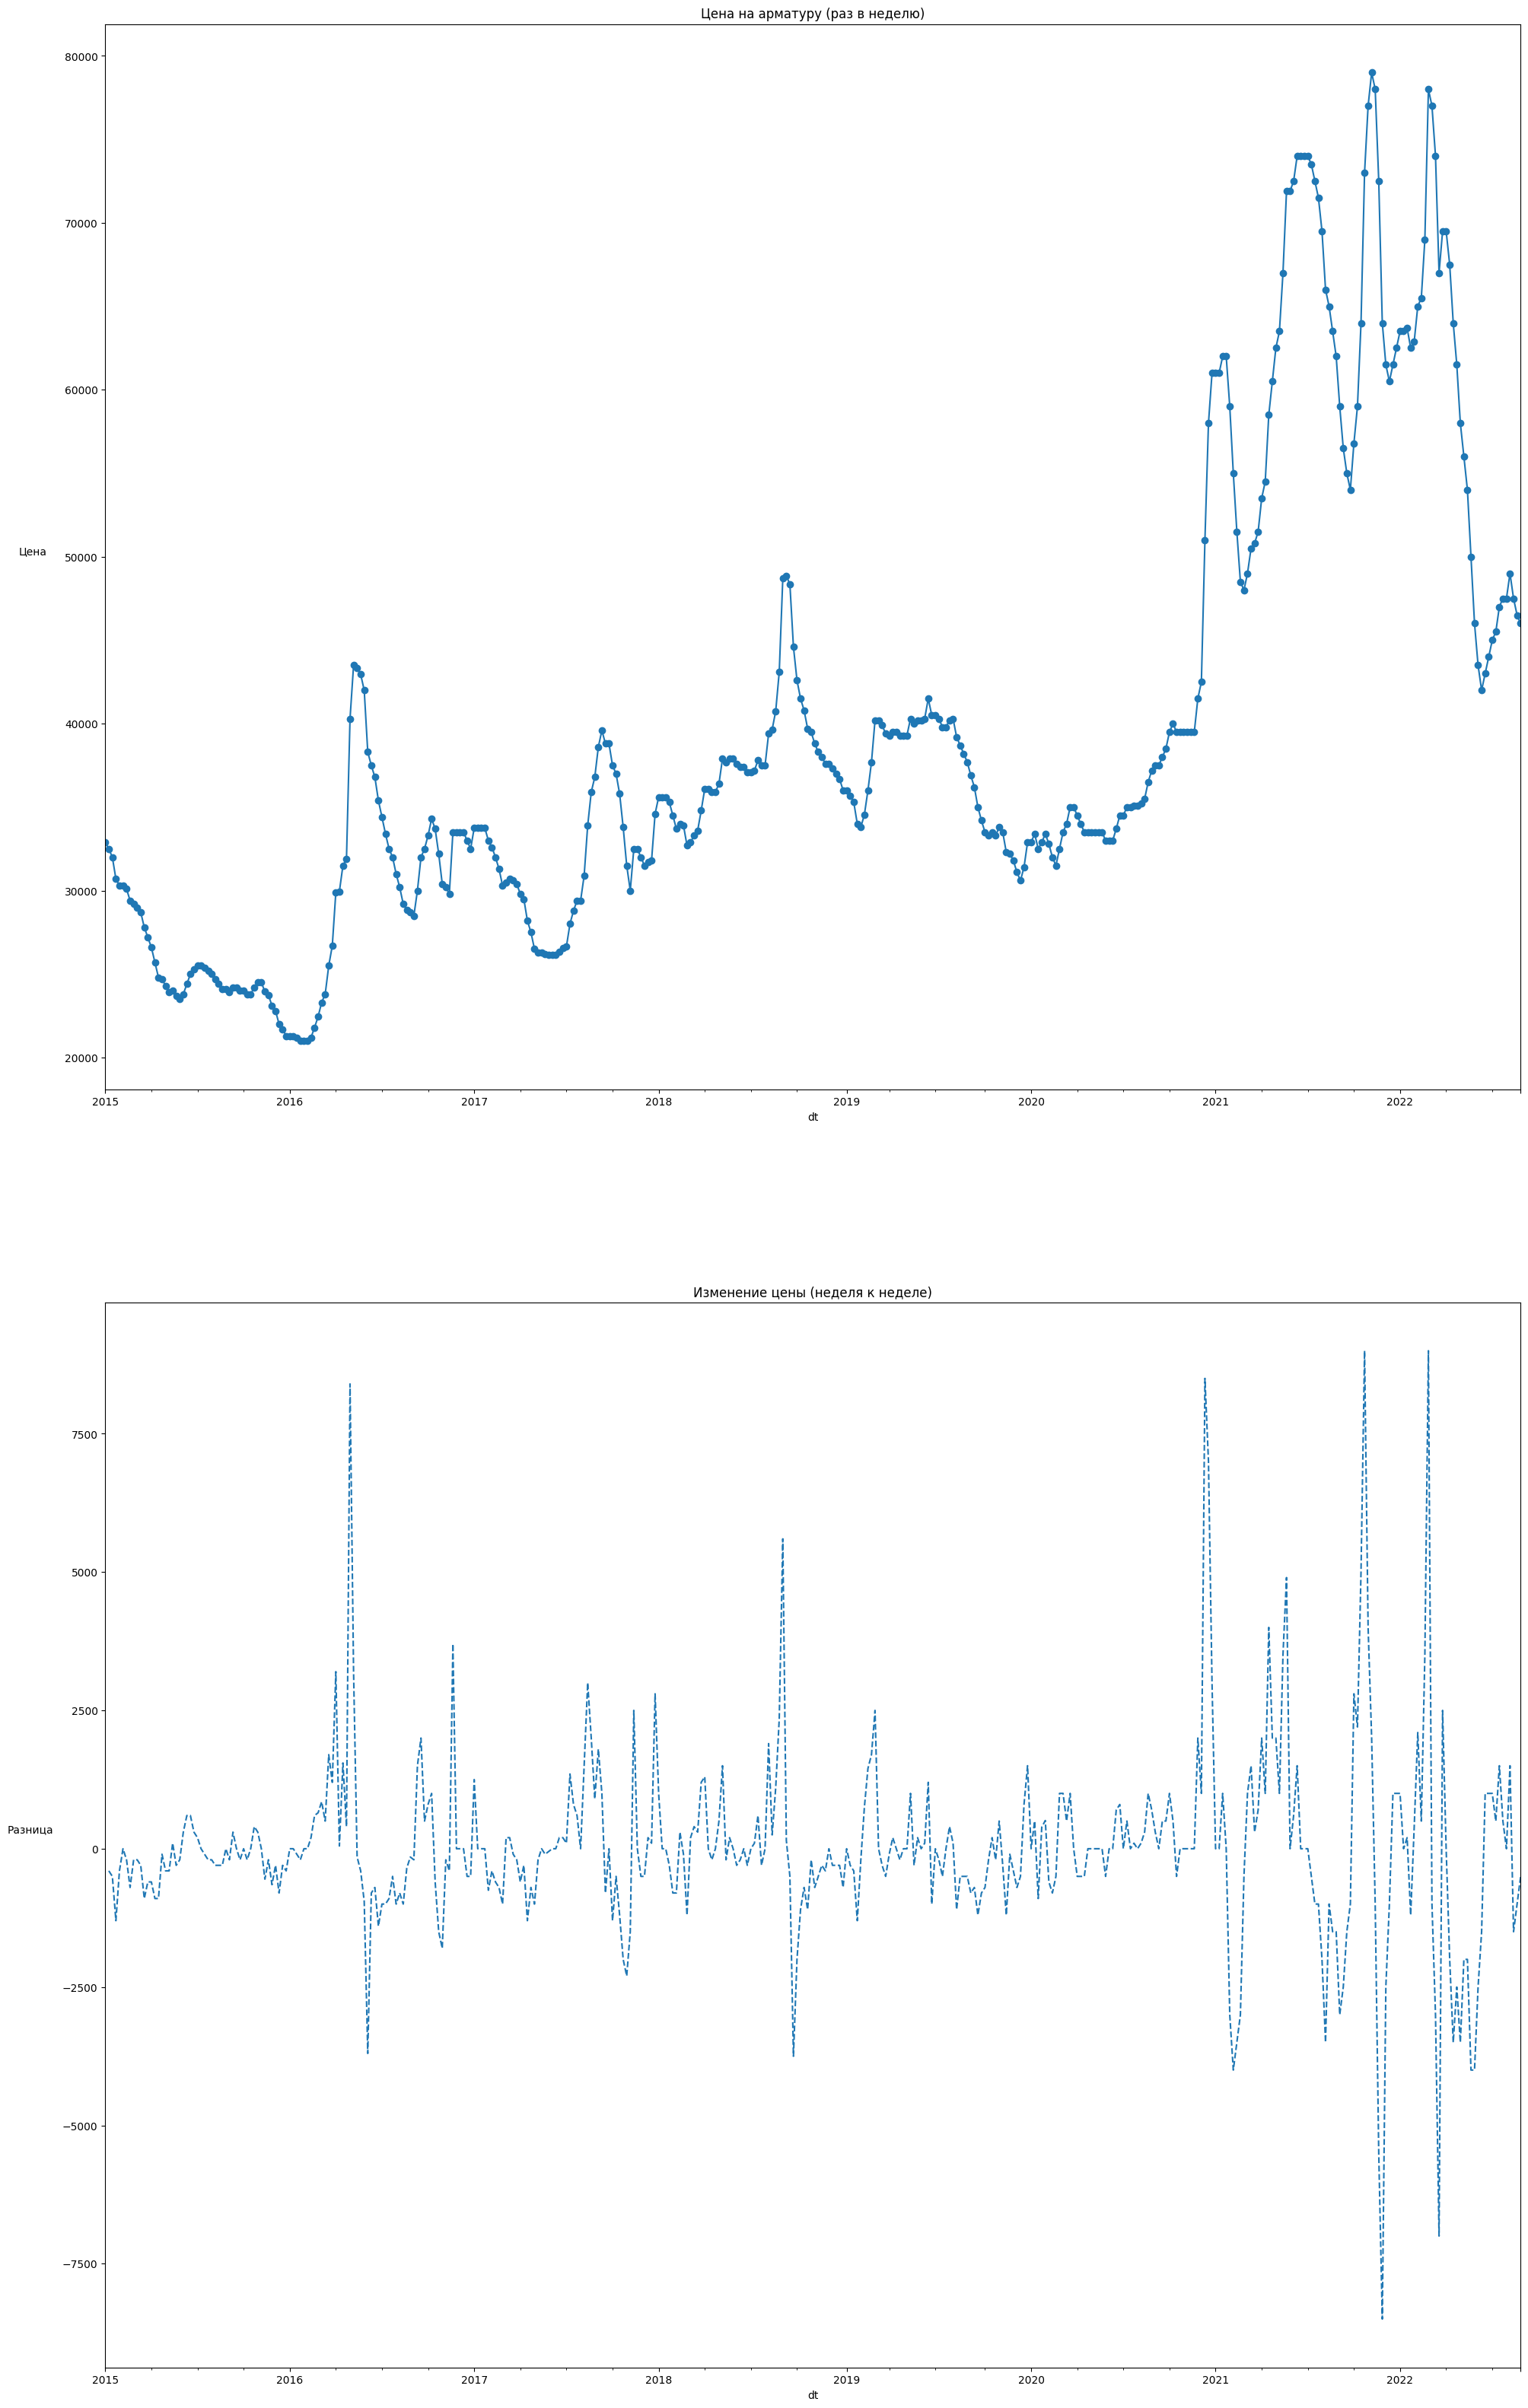

In [12]:
df_ts['Цена_разница_неделя'] = df_ts['Цена на арматуру'].diff(1)  # Разница с прошлой неделей

plt.figure(figsize=(24, 40))

ax1 = plt.subplot(211)
ax1.set_title('Цена на арматуру (раз в неделю)')
ax1.set_ylabel('Цена', rotation=0, labelpad=30)
df_ts.set_index('dt')['Цена на арматуру'].plot(ax=ax1, marker='o')

ax2 = plt.subplot(212)
ax2.set_title('Изменение цены (неделя к неделе)')
ax2.set_ylabel('Разница', rotation=0, labelpad=30)
df_ts.set_index('dt')['Цена_разница_неделя'].plot(ax=ax2, marker='', linestyle='dashed')

plt.show()

In [13]:
df_ts.replace(np.nan, 0, inplace=True)

In [14]:
df_ts.head(10)

,dt,Цена на арматуру,Цена_разница_неделя
0,2015-01-05,32900,0.0
1,2015-01-12,32500,-400.0
2,2015-01-19,32000,-500.0
3,2015-01-26,30700,-1300.0
4,2015-02-02,30300,-400.0
5,2015-02-09,30300,0.0
6,2015-02-16,30100,-200.0
7,2015-02-23,29400,-700.0
8,2015-03-02,29200,-200.0
9,2015-03-09,29000,-200.0


In [15]:
# проверка на стационарность первоначального ряда
result = adfuller(df_ts["Цена на арматуру"])
print("ADF Statistic:", result[0])
print("p-value:", result[1])

if result[1] < 0.05:
    print("Ряд стационарен (отвергаем H0)")
else:
    print("Ряд нестационарен (не отвергаем H0)")

ADF Statistic: -1.9258699893713456
p-value: 0.31999061025699155
Ряд нестационарен (не отвергаем H0)


In [16]:
# проверка на стационарность diff ряда
result = adfuller(df_ts["Цена_разница_неделя"])
print("ADF Statistic:", result[0])
print("p-value:", result[1])

if result[1] < 0.05:
    print("Ряд стационарен (отвергаем H0)")
else:
    print("Ряд нестационарен (не отвергаем H0)")

ADF Statistic: -7.711973437154185
p-value: 1.2568518586885597e-11
Ряд стационарен (отвергаем H0)


In [17]:
from scipy.signal import medfilt

df_ts["Цена на арматуру (сглаженная)"] = medfilt(df_ts["Цена_разница_неделя"], kernel_size=5)

In [18]:
# проверка на стационарность diff ряда после сглаживания
result = adfuller(df_ts["Цена на арматуру (сглаженная)"])
print("ADF Statistic:", result[0])
print("p-value:", result[1])

if result[1] < 0.05:
    print("Ряд стационарен (отвергаем H0)")
else:
    print("Ряд нестационарен (не отвергаем H0)")

ADF Statistic: -7.237213964014841
p-value: 1.9255395178881053e-10
Ряд стационарен (отвергаем H0)


In [19]:
# Нормализация данных (LSTM лучше работает с масштабированными данными)
scaler = MinMaxScaler(feature_range=(0, 1))
df_ts["Цена на арматуру (сглаженная)"] = scaler.fit_transform(df_ts[["Цена на арматуру (сглаженная)"]])

# Разделение на тренировочный и тестовый наборы
train_size = int(len(df_ts) * 0.8)  # 80% на обучение, 20% на тест
train, test = df_ts.iloc[:train_size], df_ts.iloc[train_size:]


In [20]:
# 4. Создание окон временного ряда
import numpy as np

def create_sequences(df_ts, seq_length):
    X, y = [], []
    for i in range(len(df_ts) - seq_length):
        X.append(df_ts.iloc[i:i+seq_length].values)  # Используем .iloc для работы с DataFrame
        y.append(df_ts.iloc[i+seq_length].values)  # Доступ к следующему значению
    return np.array(X), np.array(y)

# Гиперпараметр: длина окна (количество предыдущих дней, используемых для предсказания)
seq_length = 20

# Проверяем, что столбец существует в DataFrame
if "Цена на арматуру (сглаженная)" not in df_ts.columns:
    raise KeyError("Столбец 'Цена на арматуру (сглаженная)' не найден в df_ts!")

# Выбираем нужный столбец и передаем в функцию
X_train, y_train = create_sequences(df_ts[["Цена на арматуру (сглаженная)"]], seq_length)
X_test, y_test = create_sequences(df_ts[["Цена на арматуру (сглаженная)"]], seq_length)

# Изменение формы для LSTM (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

In [21]:
# 5. Создание и обучение LSTM-модели

# Построение модели LSTM
model = Sequential([
    LSTM(50, return_sequences=True, input_shape=(seq_length, 1)),
    Dropout(0.2),
    LSTM(50, return_sequences=False),
    Dropout(0.2),
    Dense(25),
    Dense(1)
])

# Компиляция модели
model.compile(optimizer="adam", loss="mse")

# Обучение модели
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=50, batch_size=16, verbose=1)


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 12s 42ms/step - loss: 0.1059 - val_loss: 0.0224
Epoch 2/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0241 - val_loss: 0.0196
Epoch 3/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0203 - val_loss: 0.0197
Epoch 4/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0217 - val_loss: 0.0199
Epoch 5/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0214 - val_loss: 0.0178
Epoch 6/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0226 - val_loss: 0.0177
Epoch 7/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0181 - val_loss: 0.0174
Epoch 8/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0176 - val_loss: 0.0160
Epoch 9/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0173 - val_loss: 0.0151
Epoch 10/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0143 - val_loss: 0.0142
Epoch 11/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0173 - val_loss: 0.0131
Epoch 12/50
24/24 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.

12/12 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step
MAE: 367.21
RMSE: 517.28
Общая длина df_ts: 400
train_size: 320, seq_length: 20
Длина df_ts после train_size + seq_length: 60
Размер y_test_inv: (380, 1)
Размер y_pred_inv: (380, 1)
Последние 10 дат в df_ts:
390   2022-06-27
391   2022-07-04
392   2022-07-11
393   2022-07-18
394   2022-07-25
395   2022-08-01
396   2022-08-08
397   2022-08-15
398   2022-08-22
399   2022-08-29
Name: dt, dtype: datetime64[ns]
Первые 10 дат тестового набора:
340   2021-07-12
341   2021-07-19
342   2021-07-26
343   2021-08-02
344   2021-08-09
345   2021-08-16
346   2021-08-23
347   2021-08-30
348   2021-09-06
349   2021-09-13
Name: dt, dtype: datetime64[ns]


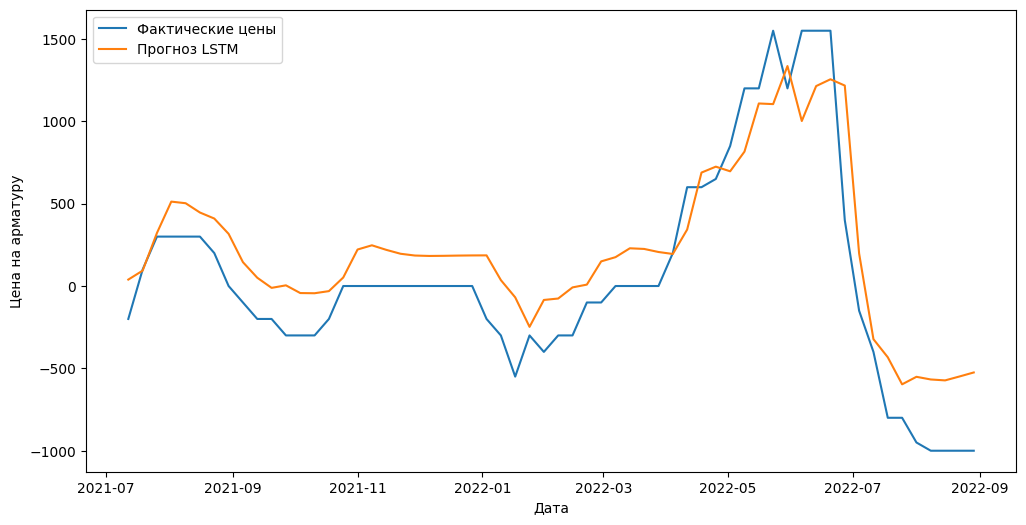

In [22]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Предсказания модели
y_pred = model.predict(X_test)

# Обратное масштабирование
y_test_inv = scaler.inverse_transform(y_test.reshape(-1, 1))
y_pred_inv = scaler.inverse_transform(y_pred)

# Оценка ошибок
mae = mean_absolute_error(y_test_inv, y_pred_inv)
rmse = np.sqrt(mean_squared_error(y_test_inv, y_pred_inv))

print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")

# Проверка размеров данных
print(f"Общая длина df_ts: {len(df_ts)}")
print(f"train_size: {train_size}, seq_length: {seq_length}")
print(f"Длина df_ts после train_size + seq_length: {len(df_ts.iloc[train_size + seq_length:])}")
print(f"Размер y_test_inv: {y_test_inv.shape}")
print(f"Размер y_pred_inv: {y_pred_inv.shape}")

# Проверяем индексы временных меток
print("Последние 10 дат в df_ts:")
print(df_ts["dt"].tail(10))

print("Первые 10 дат тестового набора:")
print(df_ts["dt"].iloc[train_size + seq_length:train_size + seq_length + 10])

# Приведение размеров временных меток и предсказаний к общему минимуму
min_length = min(len(df_ts["dt"].iloc[train_size + seq_length:]), len(y_test_inv))
dates = df_ts["dt"].iloc[train_size + seq_length:train_size + seq_length + min_length]
y_test_inv = y_test_inv[:min_length].flatten()
y_pred_inv = y_pred_inv[:min_length].flatten()

# Визуализация предсказаний
plt.figure(figsize=(12, 6))
plt.plot(dates, y_test_inv, label="Фактические цены")
plt.plot(dates, y_pred_inv, label="Прогноз LSTM")
plt.xlabel("Дата")
plt.ylabel("Цена на арматуру")
plt.legend()
plt.show()

